### **Importing Required Libraries**

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random
import os
from zipfile import ZipFile
from skimage.io import imread, imshow
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model 
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense, Dropout, Activation, BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import warnings
warnings.filterwarnings('ignore')


### **Import Train and Test Data**

In [2]:
# extracting images from train and test zip files.
trainDataPath = "./train.zip"
testDataPath = "./test1.zip"
ZipFile(trainDataPath,mode = "r").extractall()
ZipFile(testDataPath,mode =  "r").extractall()

In [3]:
# extracted train and test images path
train_path = './train'
test_path = './test1'

In [4]:
# Defining some variables
size  = 128
channels = 3
batch_size = 32
epochs = 50
width=128
height=128

### **Preparing Training Data**

In [5]:
# adding images names in dataframe with category.
filenames = os.listdir(train_path)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'cat':
        categories.append(category)
    else:
        categories.append(category)

df = pd.DataFrame({
    'Image': filenames,
    'Category': categories})
df.head()

,Image,Category
0,dog.5094.jpg,dog
1,dog.2195.jpg,dog
2,cat.2834.jpg,cat
3,cat.6896.jpg,cat
4,dog.5669.jpg,dog


### **Preparing Testing Data**

In [6]:
test_files = os.listdir(test_path)
df_test = pd.DataFrame({'Image':test_files})

df_test.head()

,Image
0,8874.jpg
1,6987.jpg
2,12170.jpg
3,8657.jpg
4,12071.jpg


### Checking the Total Count

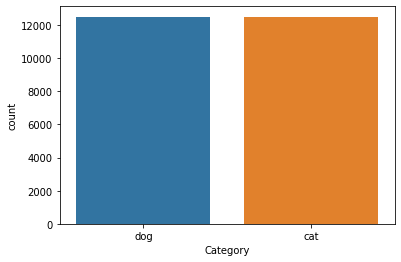

In [7]:
sns.countplot(x='Category',data=df)
plt.show()

**We can see that We have 12000 cats and 12000 dogs images.**

### Let us view some of the images of **Cat** 

In [8]:
cat_files = [file for file in filenames if file.split('.')[0] == 'cat']

def plotImages(file):
    r = random.sample(file, 9)
        
    a = 3  # number of rows
    b = 3  # number of columns
    c = 1  # initialize plot counter

    fig = plt.figure(figsize=(14,10))

    for i in range(len(r)):
        plt.subplot(a, b, c)
        img = mpimg.imread('./train/'+ r[i])
        plt.imshow(img)
        plt.axis('off')
        c = c + 1

    plt.show()
    

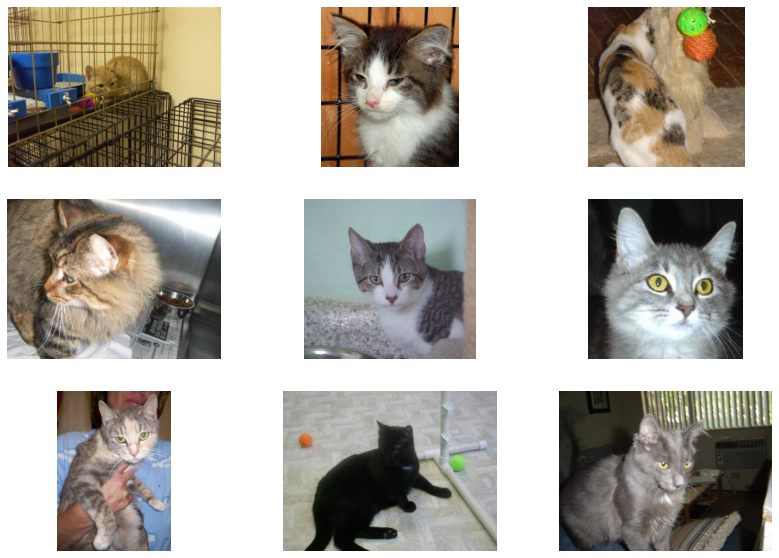

In [9]:
plotImages(cat_files)

### Let us view some of the images of **Dog** 

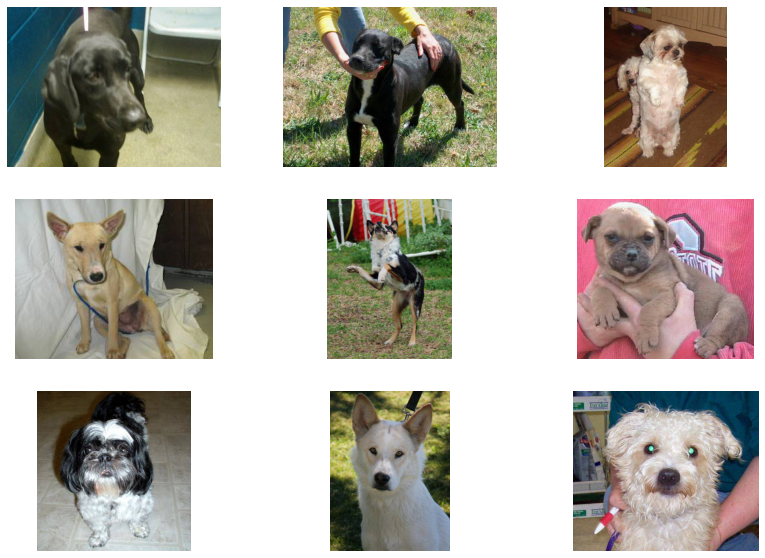

In [10]:
dog_files = [file for file in filenames if file.split('.')[0] == 'dog']
plotImages(dog_files)

### **Train & Validation Split**

In [11]:
train_df, validation_df = train_test_split(df, test_size=0.20, random_state=50)
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

### **Data Augmentation**

In [12]:
# Augmentation on training data and only scaling validation and test data.
train_datagen = ImageDataGenerator(
    rotation_range=40,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)


In [13]:
train_dataset = train_datagen.flow_from_dataframe(
    train_df, 
    directory = train_path, 
    x_col='Image',
    y_col='Category',
    target_size=(size,size),
    class_mode='categorical',
    batch_size=batch_size
)

validation_dataset = validation_datagen.flow_from_dataframe(
    validation_df, 
    directory = train_path, 
    x_col = 'Image',
    y_col = 'Category',
    target_size= (size,size),
    class_mode = 'categorical',
    batch_size = batch_size)

test_dataset = test_datagen.flow_from_dataframe(
    df_test, 
    directory=test_path, 
    x_col='Image',
    y_col=None,
    class_mode=None,
    target_size= (size,size),
    batch_size=batch_size,
    shuffle=False
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


### **Model Building**

#### CNN Model

In [14]:

### Initializing the CNN

model = Sequential()

### Step 1 - Convolution 32x3x3

model.add(Conv2D(32, (3, 3),                            ## 32 - number of feature detectors, 3-rows and 3-cols                  
                             input_shape=(128, 128, 3),      ## fixed size of image to standardize dataset + 3d array for color img (reverse order for Tensorflow backend)
                             activation = 'relu'))         ## to make sure there is no negative values in pixel maps to have non-linearity


### Step 2 - Max Pooling

model.add(MaxPooling2D(pool_size = (2,2)))            ## dims 2x2

model.add(Dropout(rate = 0.25))

### Step 2b - add additional convolutional layer for better result (from 50% to 80% accuracy)

model.add(Conv2D(32, (3, 3), activation = 'relu'))      ## No input shape as it was already done
model.add(MaxPooling2D(pool_size = (2,2)))            ## dims 2x2

model.add(Dropout(rate = 0.2))


### Step 2c - add additional convolutional layer for better result (from 80% to 90% accuracy)

model.add(Conv2D(64, (3, 3), activation = 'relu'))      ## No input shape as it was already done
model.add(MaxPooling2D(pool_size = (2,2)))            ## dims 2x2

model.add(Dropout(rate = 0.3))


### Step 2d - add additional convolutional layer for better result (from 80% to 90% accuracy)

model.add(Conv2D(128, (3, 3), activation = 'relu'))      ## No input shape as it was already done
model.add(MaxPooling2D(pool_size = (2,2)))            ## dims 2x2

model.add(Dropout(rate = 0.4))


### Step 3 - Flattening to one single vector

model.add(Flatten())


### Step 4 - Full connection

# Hidden layer - 128 as a experience guess

model.add(Dense(activation = 'relu', units = 128))


# Output layer 

model.add(Dense(2, activation='softmax'))


In [15]:
#The following is the model summary of the model:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        1

#### Specifying the optimizers and compile the model

In [16]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Setup Callbacks

In [17]:
checkpoint_filepath = 'best_weights.hdf5'

earlyStop = EarlyStopping(monitor='val_accuracy', patience=4, 
                        verbose=1, mode='auto',restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, 
                                      save_weights_only=False, 
                                      monitor='val_accuracy',
                                      mode='auto', 
                                      save_best_only=True)
# learningrate = ReduceLROnPlateau(monitor='val_accuracy',
#                                           mode='max',
#                                           min_delta=0.03, patience=3, 
#                                           factor=.5,
#                                           min_lr=0.00001, verbose=1)

callbacks = [earlyStop, checkpoint]

###  Model Fitting

In [18]:
history = model.fit(train_dataset, 
                        validation_data = validation_dataset,
                        epochs=epochs, 
                        callbacks=callbacks)

Epoch 1/50
625/625 [==============================] - 136s 211ms/step - loss: 0.6959 - accuracy: 0.5264 - val_loss: 0.6588 - val_accuracy: 0.6006
Epoch 2/50
625/625 [==============================] - 131s 209ms/step - loss: 0.6611 - accuracy: 0.5945 - val_loss: 0.5964 - val_accuracy: 0.6872
Epoch 3/50
625/625 [==============================] - 130s 209ms/step - loss: 0.6106 - accuracy: 0.6661 - val_loss: 0.5624 - val_accuracy: 0.7142
Epoch 4/50
625/625 [==============================] - 129s 207ms/step - loss: 0.5773 - accuracy: 0.6970 - val_loss: 0.4951 - val_accuracy: 0.7634
Epoch 5/50
625/625 [==============================] - 129s 207ms/step - loss: 0.5658 - accuracy: 0.7050 - val_loss: 0.4953 - val_accuracy: 0.7646
Epoch 6/50
625/625 [==============================] - 129s 206ms/step - loss: 0.5457 - accuracy: 0.7237 - val_loss: 0.4854 - val_accuracy: 0.7594
Epoch 7/50
625/625 [==============================] - 129s 206ms/step - loss: 0.5295 - accuracy: 0.7328 - val_loss: 0.4558 -

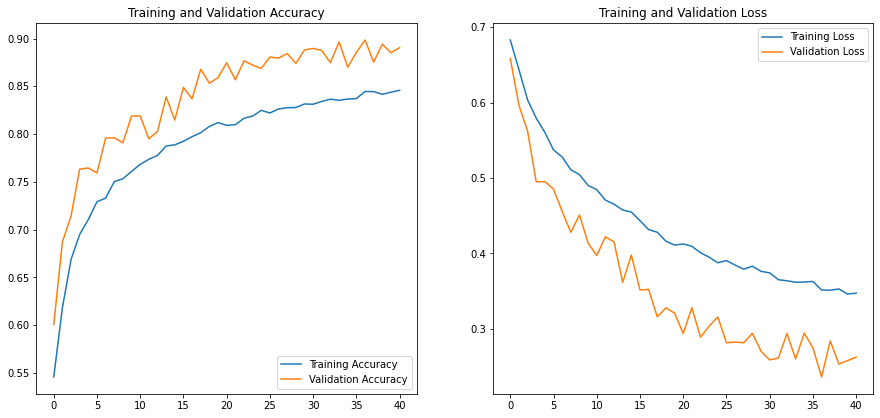

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Prediction**

In [20]:
predict = model.predict(test_dataset)

In [21]:
# For categoral classication the prediction will come with probability of each category. 
# So we will pick the category that have the highest probability with numpy average max
df_test['category'] = np.argmax(predict, axis=-1)
df_test.head()

,Image,category
0,8874.jpg,0
1,6987.jpg,0
2,12170.jpg,1
3,8657.jpg,0
4,12071.jpg,0


In [22]:
label_map = dict((v,k) for k,v in train_dataset.class_indices.items())
df_test['category'] = df_test['category'].replace(label_map)

### See predicted result 

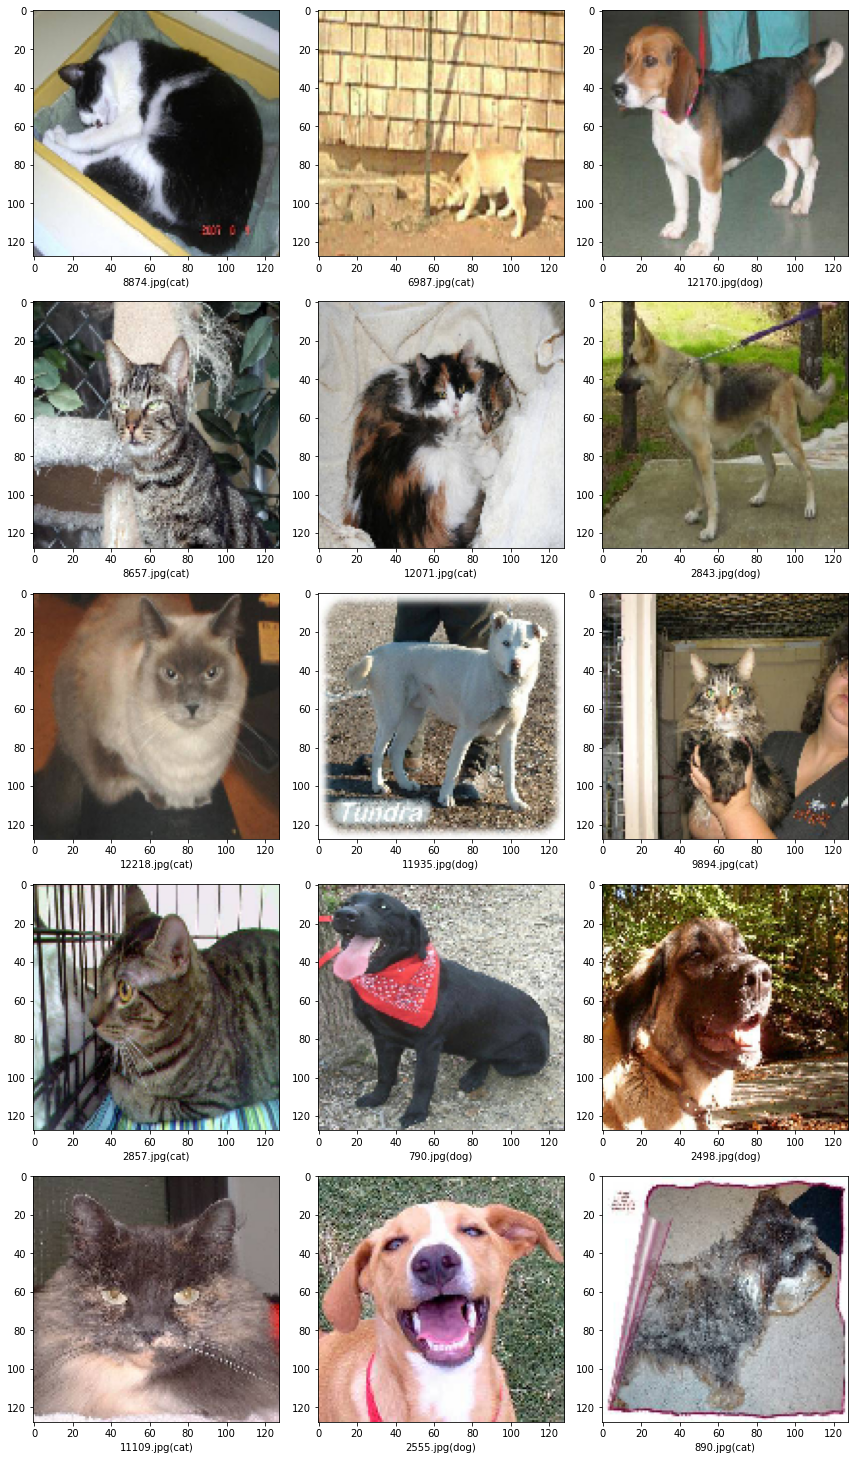

In [23]:
sample_test = df_test.head(15)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['Image']
    category = row['category']
    img = load_img(test_path+'/' + filename, target_size=(size,size))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()